In [1]:
#%%html
#<link rel="stylesheet" href="style/style.css">

# Lake model continued

In the previous week you used the lake problem as a means of getting aquinted with the workbench. In this assignment we will continue with the lake problem, focussing explicitly on using it for open exploration. You can use the second part of [this tutorial](https://emaworkbench.readthedocs.io/en/latest/indepth_tutorial/open-exploration.html) for help.

**It is paramount that you are using the lake problem with 100 decision variables, rather than the one found on the website with the seperate anthropogenic release decision**

## Apply sensitivity analysis
There is substantial support in the ema_workbench for global sensitivity. For this, the workbench relies on [SALib](https://salib.readthedocs.io/en/latest/) and feature scoring which is a machine learning alternative for global sensitivity analysis. 


1. Apply Sobol with 3 seperate release policies (0, 0.05, and 0.1) and analyse the results for each release policy seperately focusing on the reliability objective. Do the sensitivities change depending on the release policy? Can you explain why or why not?

*hint: you can use sobol sampling for the uncertainties, and set policies to a list with the 3 different release policies. Next, for the analysis using logical indexing on the experiment.policy column you can select the results for each seperate release policy and apply sobol to each of the three seperate release policies. If this sounds too complicated, just do it on each release policy seperately.*



Use the Sobol sampling functionality included in the Workbench to perform experiments with a sample size of N=50, then analyze the results with SALib for the same three indicators. This requires specifying the keyword argument 'uncertainty_sampling' of perform_experiments. Note that when using Sobol sampling, the meaning of the keyword argument scenarios changes a bit. In order to properly estimate Sobol scores as well as interaction effects, you require N * (2D+2) scenarios, where D is the number of uncertain parameters, and N is the value for scenarios passed to perform_experiments. Repeat the analysis for larger sample sizes, with N=250 and N=1000. How can we interpret the first-order and total indices? Are these sample sizes sufficient for a stable estimation of the indices? You'll need to use the get_SALib_problem function to convert your Workbench experiments to a problem definition that you can pass to the SALib analysis function.



In [2]:
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from ema_workbench import (Model, RealParameter, Constant, ScalarOutcome, TimeSeriesOutcome, perform_experiments, ema_logging, SequentialEvaluator, MultiprocessingEvaluator)
from ema_workbench.em_framework.evaluators import LHS, SOBOL, MORRIS
from ema_workbench.analysis import feature_scoring, pairs_plotting
from ema_workbench.analysis.scenario_discovery_util import RuleInductionType
from ema_workbench.em_framework.salib_samplers import get_SALib_problem
from SALib.analyze import sobol
import pandas as pd
import seaborn as sns

In [3]:
# Set up model

import lakemodel_function as lake

model = Model('Lakemodel', function=lake.lake_problem)

uncertainties = [RealParameter('mean', 0.01, 0.5),
                 RealParameter('stdev', 0.001, 0.005),
                 RealParameter('b', 0.1, 0.45),
                 RealParameter('q', 2, 4.5),
                 RealParameter('delta', 0.93, 0.99)]

outcomes = [ScalarOutcome('max_P', ScalarOutcome.MINIMIZE),
            ScalarOutcome('utility', ScalarOutcome.MAXIMIZE),
            ScalarOutcome('inertia', ScalarOutcome.INFO),
            ScalarOutcome('reliability', ScalarOutcome.MAXIMIZE)]
# assumption that inertia does not matter and is only there to provide info.

model.uncertainties = uncertainties

# model.levers = [RealParameter("l" + str(number),0,0.1) for number in range(0,100)]

model.outcomes = outcomes

In [4]:
# Model run
processes = 8
D = len(uncertainties)
i = 0
experiments = {}
outcomes = {}
Si = {}
indexes = []

for l_value in [0, 0.05, 0.1]:

    model.constants = [Constant('l' + str(i), l_value) for i in range(100)]

    for N in [50, 250, 1000]:

        n_scenarios = N * (2 * D + 2)
        print('N =',str(N))
        print('Release decision:',str(l_value))
        print('Scenarios to perform:',str(n_scenarios))
        
        # This will be useful later
        indexes.append('l'+str(l_value)+'_N'+str(N))
        
        # It seems like the code already does this transformation for us, then wtf Jan? That was pretty stupid confusing.

        # This bit of code is actually preventing a warning from SAlib for some reason, the one about the 2^n scenarios
        ema_logging.log_to_stderr(ema_logging.INFO)
        # Why 7200 cases when it is 600 scenarios wtf? Maybe related to the previous?

        with MultiprocessingEvaluator(model, processes) as evaluator:
            # I think no policies because levers is a constant?
            experiments[indexes[-1]], outcomes[indexes[-1]] = evaluator.perform_experiments(scenarios = N, uncertainty_sampling=SOBOL)
            # Still have to add more Sobol crap here
            problem = get_SALib_problem(model.uncertainties)
            Si[indexes[-1]] = sobol.analyze(problem, outcomes[indexes[-1]]['max_P'], calc_second_order=True, print_to_console=False)

N = 50
Release decision: 0
Scenarios to perform: 600


[MainProcess/INFO] pool started
C:\Users\David2\anaconda3\envs\gds\lib\site-packages\SALib\sample\saltelli.py:52: FutureWarning: 
        Convergence properties of the Sobol' sequence is only valid if `N` = 2^n.
        SALib will continue on, but results may have issues.
        In future, this will raise an error.
        
  warnings.warn(msg, FutureWarning)
[MainProcess/INFO] performing 600 scenarios * 1 policies * 1 model(s) = 600 experiments
[MainProcess/INFO] 60 cases completed
[MainProcess/INFO] 120 cases completed
[MainProcess/INFO] 180 cases completed
[MainProcess/INFO] 240 cases completed
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 360 cases completed
[MainProcess/INFO] 420 cases completed
[MainProcess/INFO] 480 cases completed
[MainProcess/INFO] 540 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


N = 250
Release decision: 0
Scenarios to perform: 3000


[MainProcess/INFO] pool started
[MainProcess/INFO] performing 3000 scenarios * 1 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


N = 1000
Release decision: 0
Scenarios to perform: 12000


[MainProcess/INFO] pool started
[MainProcess/INFO] performing 12000 scenarios * 1 policies * 1 model(s) = 12000 experiments
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 3600 cases completed
[MainProcess/INFO] 4800 cases completed
[MainProcess/INFO] 6000 cases completed
[MainProcess/INFO] 7200 cases completed
[MainProcess/INFO] 8400 cases completed
[MainProcess/INFO] 9600 cases completed
[MainProcess/INFO] 10800 cases completed
[MainProcess/INFO] 12000 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


N = 50
Release decision: 0.05
Scenarios to perform: 600


[MainProcess/INFO] pool started
[MainProcess/INFO] performing 600 scenarios * 1 policies * 1 model(s) = 600 experiments
[MainProcess/INFO] 60 cases completed
[MainProcess/INFO] 120 cases completed
[MainProcess/INFO] 180 cases completed
[MainProcess/INFO] 240 cases completed
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 360 cases completed
[MainProcess/INFO] 420 cases completed
[MainProcess/INFO] 480 cases completed
[MainProcess/INFO] 540 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


N = 250
Release decision: 0.05
Scenarios to perform: 3000


[MainProcess/INFO] pool started
[MainProcess/INFO] performing 3000 scenarios * 1 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


N = 1000
Release decision: 0.05
Scenarios to perform: 12000


[MainProcess/INFO] pool started
[MainProcess/INFO] performing 12000 scenarios * 1 policies * 1 model(s) = 12000 experiments
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 3600 cases completed
[MainProcess/INFO] 4800 cases completed
[MainProcess/INFO] 6000 cases completed
[MainProcess/INFO] 7200 cases completed
[MainProcess/INFO] 8400 cases completed
[MainProcess/INFO] 9600 cases completed
[MainProcess/INFO] 10800 cases completed
[MainProcess/INFO] 12000 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


N = 50
Release decision: 0.1
Scenarios to perform: 600


[MainProcess/INFO] pool started
[MainProcess/INFO] performing 600 scenarios * 1 policies * 1 model(s) = 600 experiments
[MainProcess/INFO] 60 cases completed
[MainProcess/INFO] 120 cases completed
[MainProcess/INFO] 180 cases completed
[MainProcess/INFO] 240 cases completed
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 360 cases completed
[MainProcess/INFO] 420 cases completed
[MainProcess/INFO] 480 cases completed
[MainProcess/INFO] 540 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


N = 250
Release decision: 0.1
Scenarios to perform: 3000


[MainProcess/INFO] pool started
[MainProcess/INFO] performing 3000 scenarios * 1 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


N = 1000
Release decision: 0.1
Scenarios to perform: 12000


[MainProcess/INFO] pool started
[MainProcess/INFO] performing 12000 scenarios * 1 policies * 1 model(s) = 12000 experiments
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 3600 cases completed
[MainProcess/INFO] 4800 cases completed
[MainProcess/INFO] 6000 cases completed
[MainProcess/INFO] 7200 cases completed
[MainProcess/INFO] 8400 cases completed
[MainProcess/INFO] 9600 cases completed
[MainProcess/INFO] 10800 cases completed
[MainProcess/INFO] 12000 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


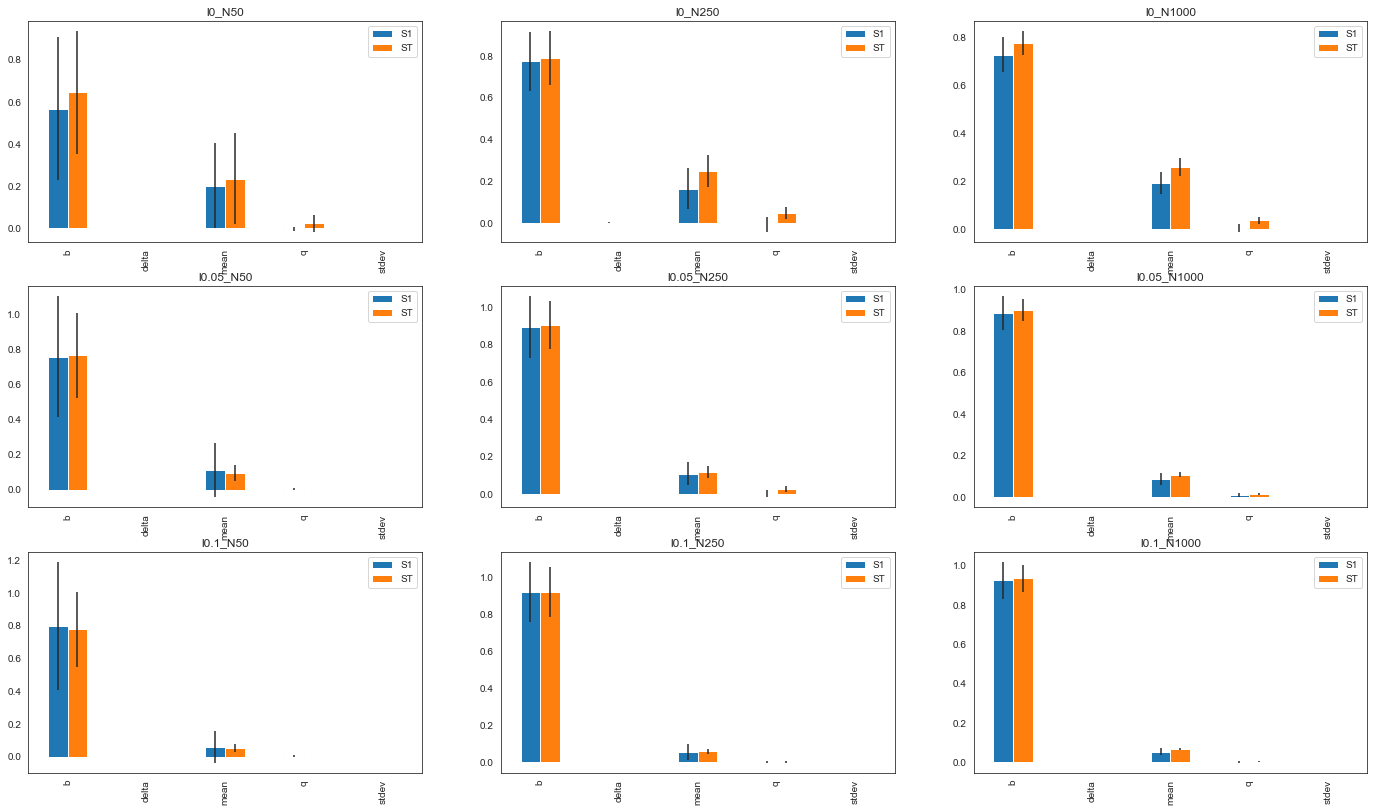

In [16]:
Si_df = {}
indices = {}
err = {}

# Get data for visual stuff
for i in indexes:

    scores_filtered = {k:Si[i][k] for k in ['ST','ST_conf','S1','S1_conf']}
    Si_df[i] = pd.DataFrame(scores_filtered, index=problem['names'])
    indices[i] = Si_df[i][['S1','ST']]
    err[i] = Si_df[i][['S1_conf','ST_conf']]
    
# Set up figure

sns.set_style('white')
fig, ax = plt.subplots(3,3)
fig.set_size_inches(24,18)
fig.subplots_adjust(bottom=0.3)

# Set up sub figures

for i in range(9):

    indices[indexes[i]].plot.bar(yerr=err[indexes[i]].values.T,ax=ax.flatten()[i])
    ax.flatten()[i].set_title(indexes[i])

plt.show()

[MainProcess/INFO] no time dimension found in results


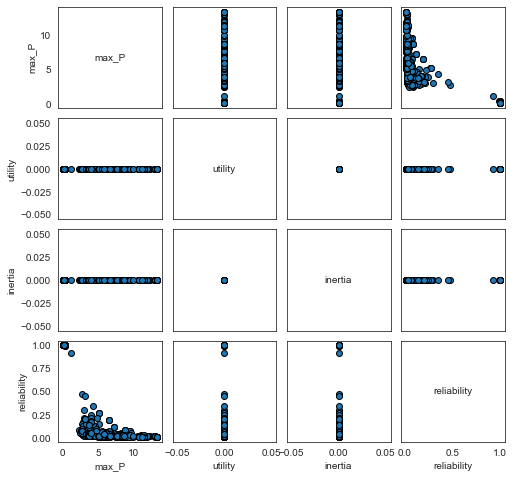

In [6]:
fig, axes = pairs_plotting.pairs_scatter(experiments['l0_N50'], outcomes['l0_N50'], legend=False)
fig.set_size_inches(8,8)
plt.show()

<div class="analysis">
I am David the inventor of S3x u can call me fishdoorbellguy.    
</div>

<div style="color: GREEN">
David: wut

2. Repeat the above analysis for the 3 release policies but now with extra trees feature scoring and for all outcomes of interest. As a bonus, use the sobol experiment results as input for extra trees, and compare the results with those resulting from latin hypercube sampling.

*hint: you can use [seaborn heatmaps](https://seaborn.pydata.org/generated/seaborn.heatmap.html) for a nice figure of the results*
